# FD001

In [1]:
!wget https://ti.arc.nasa.gov/c/6/ -O data.zip
!unzip data.zip
!pip install lifelines

--2021-04-30 16:46:11--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2021-04-30 16:46:12--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  11.85M  15.3MB/s    in 0.8s    

2021-04-30 16:46:13 (15.3 MB/s) - ‘data.zip’ saved [12425978/12425978]

Archive:  data.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt 

In [2]:
# load necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter
%matplotlib inline

In [3]:
inputdir = ""

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [4]:
# the files did not contain headers. Here we create labels based on documentation
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
df_train= pd.read_csv(inputdir+'train_FD001.txt', sep=" ", header=None, names = column_names)
df_test = pd.read_csv(inputdir+'test_FD001.txt', sep=" ", header=None, names = column_names)

# drop NULL columns
df_train.drop(df_train.columns[[26, 27]], axis=1, inplace=True)
df_test.drop(df_test.columns[[26, 27]], axis=1, inplace=True)

display(df_train)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


# Adding Failure indicators and Cycle starts

In [5]:
df_train["IsFailure"] = 0
idx_failure = (np.where(df_train["Cycle"] ==1)[0] - 1)[1:]
df_train["IsFailure"][idx_failure] = 1
df_train["CycleStart"] = df_train["Cycle"]-1
df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0,1
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0,2
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0,3
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,0,195
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,0,196
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,0,197
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,0,198


In [6]:
drop_sensors = op_settings_columns +['Sensor_1','Sensor_5','Sensor_6','Sensor_10','Sensor_16','Sensor_18','Sensor_19']
X = df_train.drop(labels=drop_sensors, axis=1)
X

,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,0,195
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,0,196
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,0,197
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,0,198


In [7]:
df_test["IsFailure"] = 0
idx_failure = (np.where(df_test["Cycle"] ==1)[0] - 1)[1:]
df_test["IsFailure"][idx_failure] = 1
df_test["CycleStart"] = df_test["Cycle"]-1
X_test = df_test[X.columns]
X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,0,0
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,0,1
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,0,2
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,0,3
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,643.24,1599.45,1415.79,553.41,2388.02,9142.37,47.69,520.69,2388.00,8213.28,8.4715,394,38.65,23.1974,0,193
13092,100,195,643.22,1595.69,1422.05,553.22,2388.05,9140.68,47.60,521.05,2388.09,8210.85,8.4512,395,38.57,23.2771,0,194
13093,100,196,643.44,1593.15,1406.82,553.04,2388.11,9146.81,47.57,521.18,2388.04,8217.24,8.4569,395,38.62,23.2051,0,195
13094,100,197,643.26,1594.99,1419.36,553.37,2388.07,9148.85,47.61,521.33,2388.08,8220.48,8.4711,395,38.66,23.2699,0,196


In [8]:
from lifelines import CoxPHFitter
cph = CoxTimeVaryingFitter()

cph.fit(X, id_col='UnitNumber', event_col='IsFailure', start_col='CycleStart', stop_col='Cycle')
cph.print_summary() 

<lifelines.CoxTimeVaryingFitter: fitted with 20631 periods, 100 subjects, 99 events>
         event col = 'IsFailure'
number of subjects = 100
 number of periods = 20631
  number of events = 99
partial log-likelihood = -114.23
  time fit was run = 2021-04-30 16:46:21 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    1.42       4.13       0.50             0.44             2.40                 1.55                11.04
Sensor_3    0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
Sensor_4    0.14       1.15       0.03             0.08             0.21                 1.08                 1.23
Sensor_7   -0.84       0.43       0.35            -1.54            -0.15                 0.21                 0.86
Sensor_8   -2.16       0.12       3.77            -9.55             5.24                 0.00               188.77
Sensor_9   -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.05
Sensor_11   4.51      90.95       1.20             2.16             6.86                 8.69               951.28
Sensor_12  -1.61       0.20       0.42            -2.42            -0.79                 0.09                 0.45
Sensor_13   6.79     884.95       3.88            -0.81            14.38                 0.44             1.76e+06
Sensor_14   0.02       1.02       0.03            -0.03             0.08                 0.97                 1.09
Sensor_15   4.32      74.95       7.04            -9.49            18.12                 0.00             7.40e+07
Sensor_17   0.25       1.29       0.15            -0.04             0.54                 0.96                 1.72
Sensor_20  -4.74       0.01       1.46            -7.59            -1.88                 0.00                 0.15
Sensor_21  -3.71       0.02       2.16            -7.93             0.52                 0.00                 1.68

              z      p   -log2(p)
covariate                        
Sensor_2   2.83 <0.005       7.74
Sensor_3   0.69   0.49       1.03
Sensor_4   4.17 <0.005      14.99
Sensor_7  -2.39   0.02       5.88
Sensor_8  -0.57   0.57       0.82
Sensor_9  -0.29   0.77       0.37
Sensor_11  3.77 <0.005      12.56
Sensor_12 -3.86 <0.005      13.14
Sensor_13  1.75   0.08       3.64
Sensor_14  0.80   0.42       1.24
Sensor_15  0.61   0.54       0.89
Sensor_17  1.68   0.09       3.42
Sensor_20 -3.25 <0.005       9.77
Sensor_21 -1.72   0.09       3.55
---
Partial AIC = 256.45
log-likelihood ratio test = 491.33 on 14 df
-log2(p) of ll-ratio test = 316.23

In [9]:
#prediction
pred_cols = ['Cycle',
 'Sensor_2',
 'Sensor_3',
 'Sensor_4',
 'Sensor_7',
 'Sensor_8',
 'Sensor_9',
 'Sensor_11',
 'Sensor_12',
 'Sensor_13',
 'Sensor_14',
 'Sensor_15',
 'Sensor_17',
 'Sensor_20',
 'Sensor_21',
 'IsFailure',
 'CycleStart']

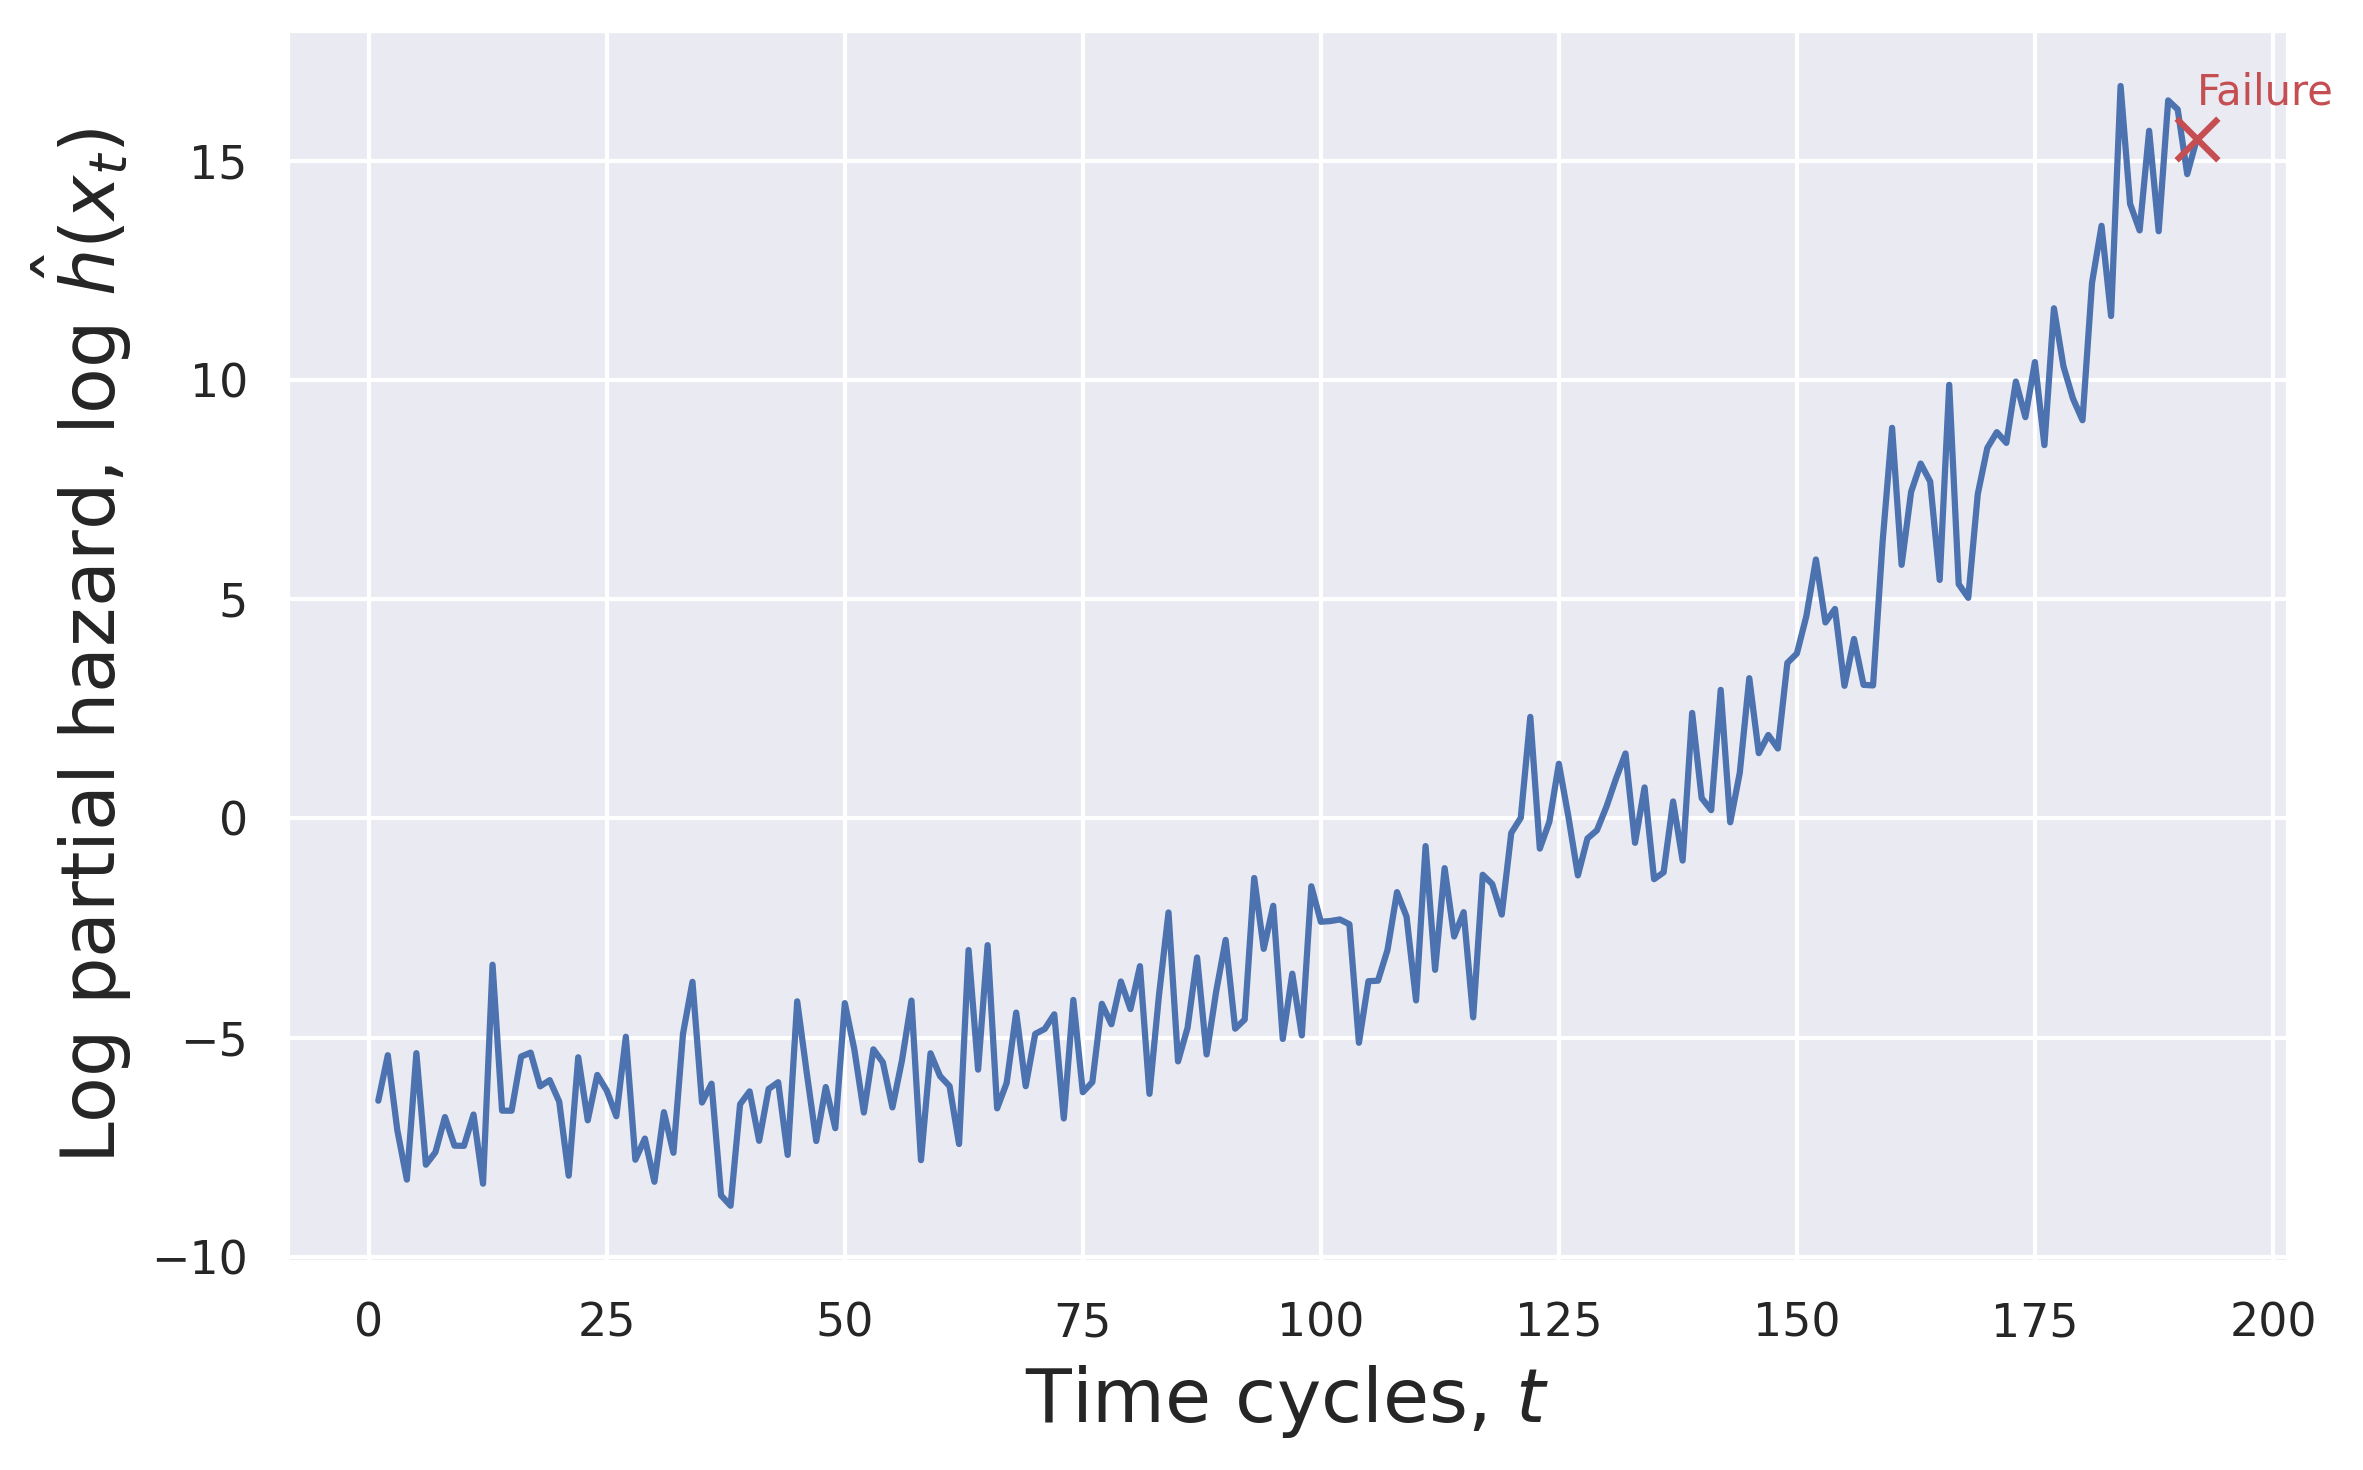

In [10]:
plt.figure(figsize=(8,5), dpi=300)


X_sub = X.loc[X['UnitNumber'] == 1]
predictions = cph.predict_partial_hazard(X_sub[pred_cols])
plt.plot(X_sub['Cycle'].values, np.log(predictions))
plt.scatter(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1], s=100, marker="x", zorder=10, c="C3")
plt.text(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]+0.8, "Failure", c="C3", fontsize=10)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.tight_layout()
plt.savefig('hazard_traj.pdf', format="pdf")
plt.show()
  

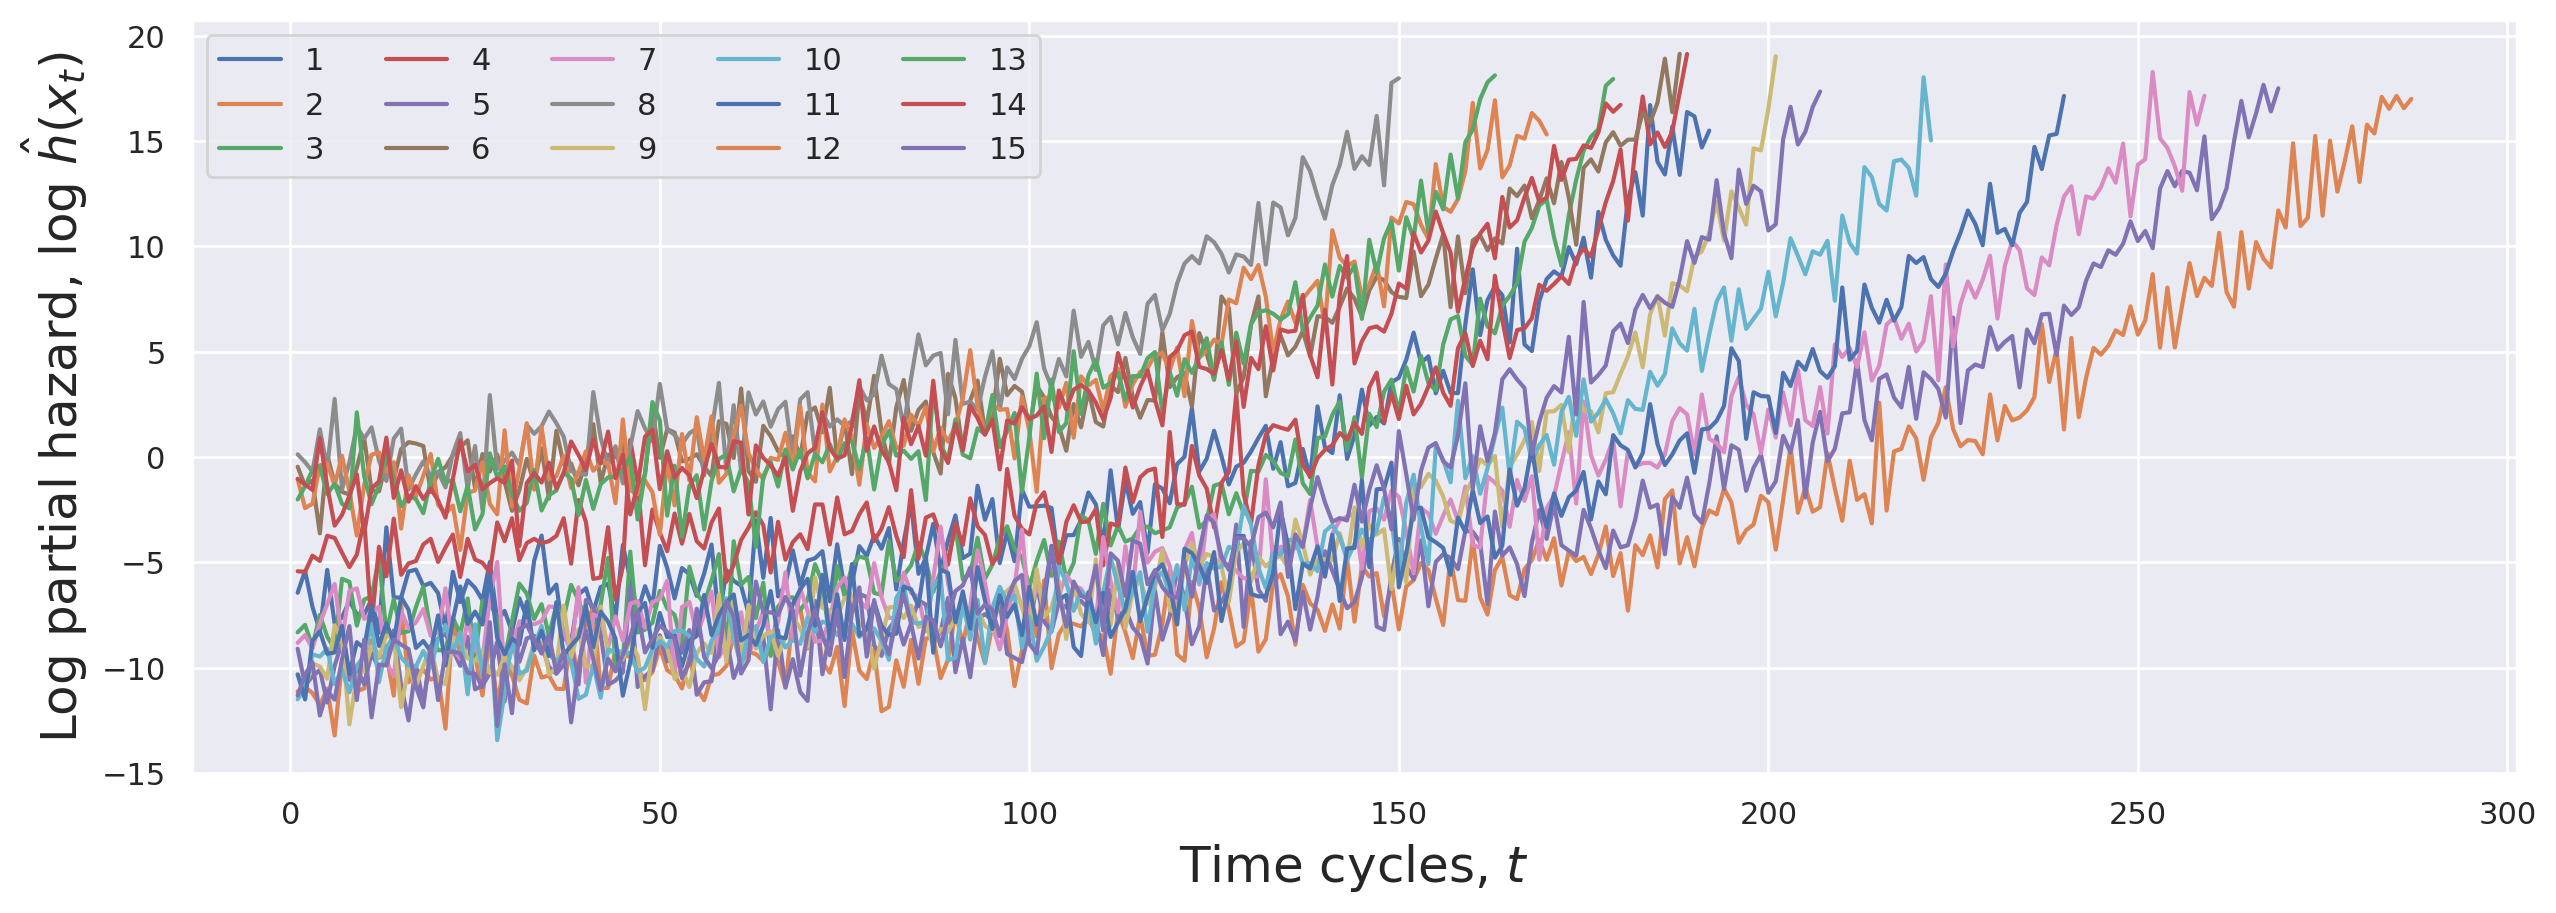

In [11]:
plt.figure(figsize=(15,5), dpi=200)

for i in trange(15):
    X_sub = X.loc[X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=i+1)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.legend(ncol=5)
#plt.ylim([10, None])
plt.show()


# Thresholding the hazard score for decision making


In [12]:
#training

llp_replacement=4000000
perf_restoration=3500000

thres_list  = np.arange(14, 21, 0.5)


rep_num= 10
machine_num = 30

optim_data_mean = []
optim_data_std = []
for thres in thres_list :
  #simulate for rep_num times
  sim_results = []
  for k in trange(rep_num):
    #in each rep select machine_num machines
    machines = np.random.choice(X['UnitNumber'].unique(), size=machine_num)    
    machine_i = []
    for i in range(machine_num):
      X_sub = X.loc[X['UnitNumber'] == machines[i]]
      X_fail = X.loc[X['UnitNumber'] == machines[i]]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep
      
      machine_i.append([is_failed, total_perf_rest, total_llp_rep, total_maintcost])

    machine_i = np.array(machine_i)
    sim_result = [thres, machine_i[:, 0].mean(),  machine_i[:, 1].sum(),  
                  machine_i[:, 2].sum(),  machine_i[:, 3].sum()]
                  

    sim_results.append(sim_result)

  sim_results = np.array(sim_results)
  optim_data_mean.append(sim_results.mean(axis=0))
  optim_data_std.append(sim_results.std(axis=0))

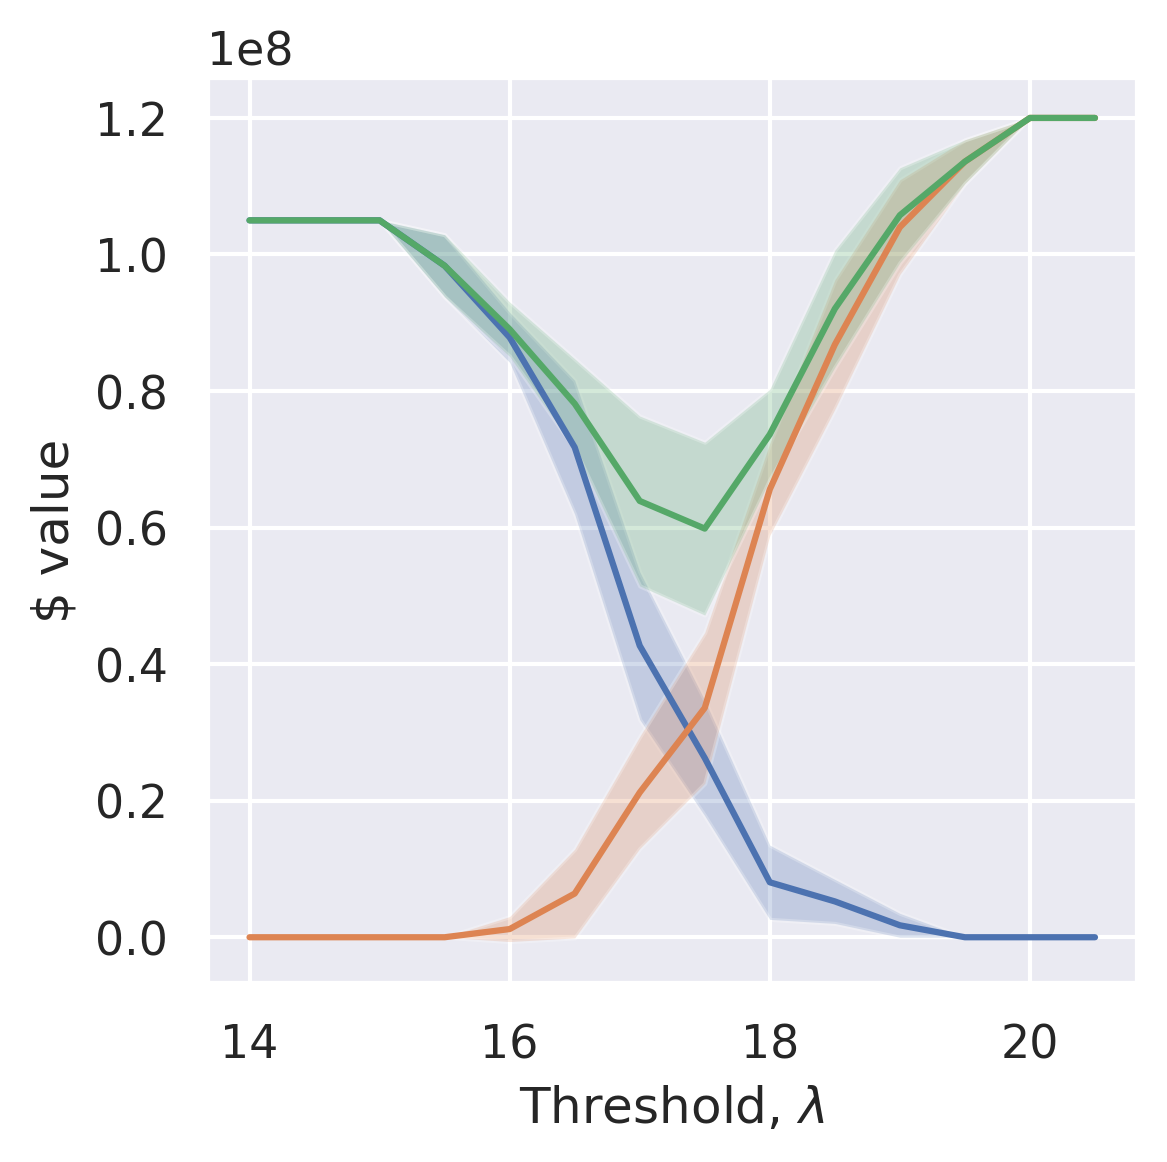

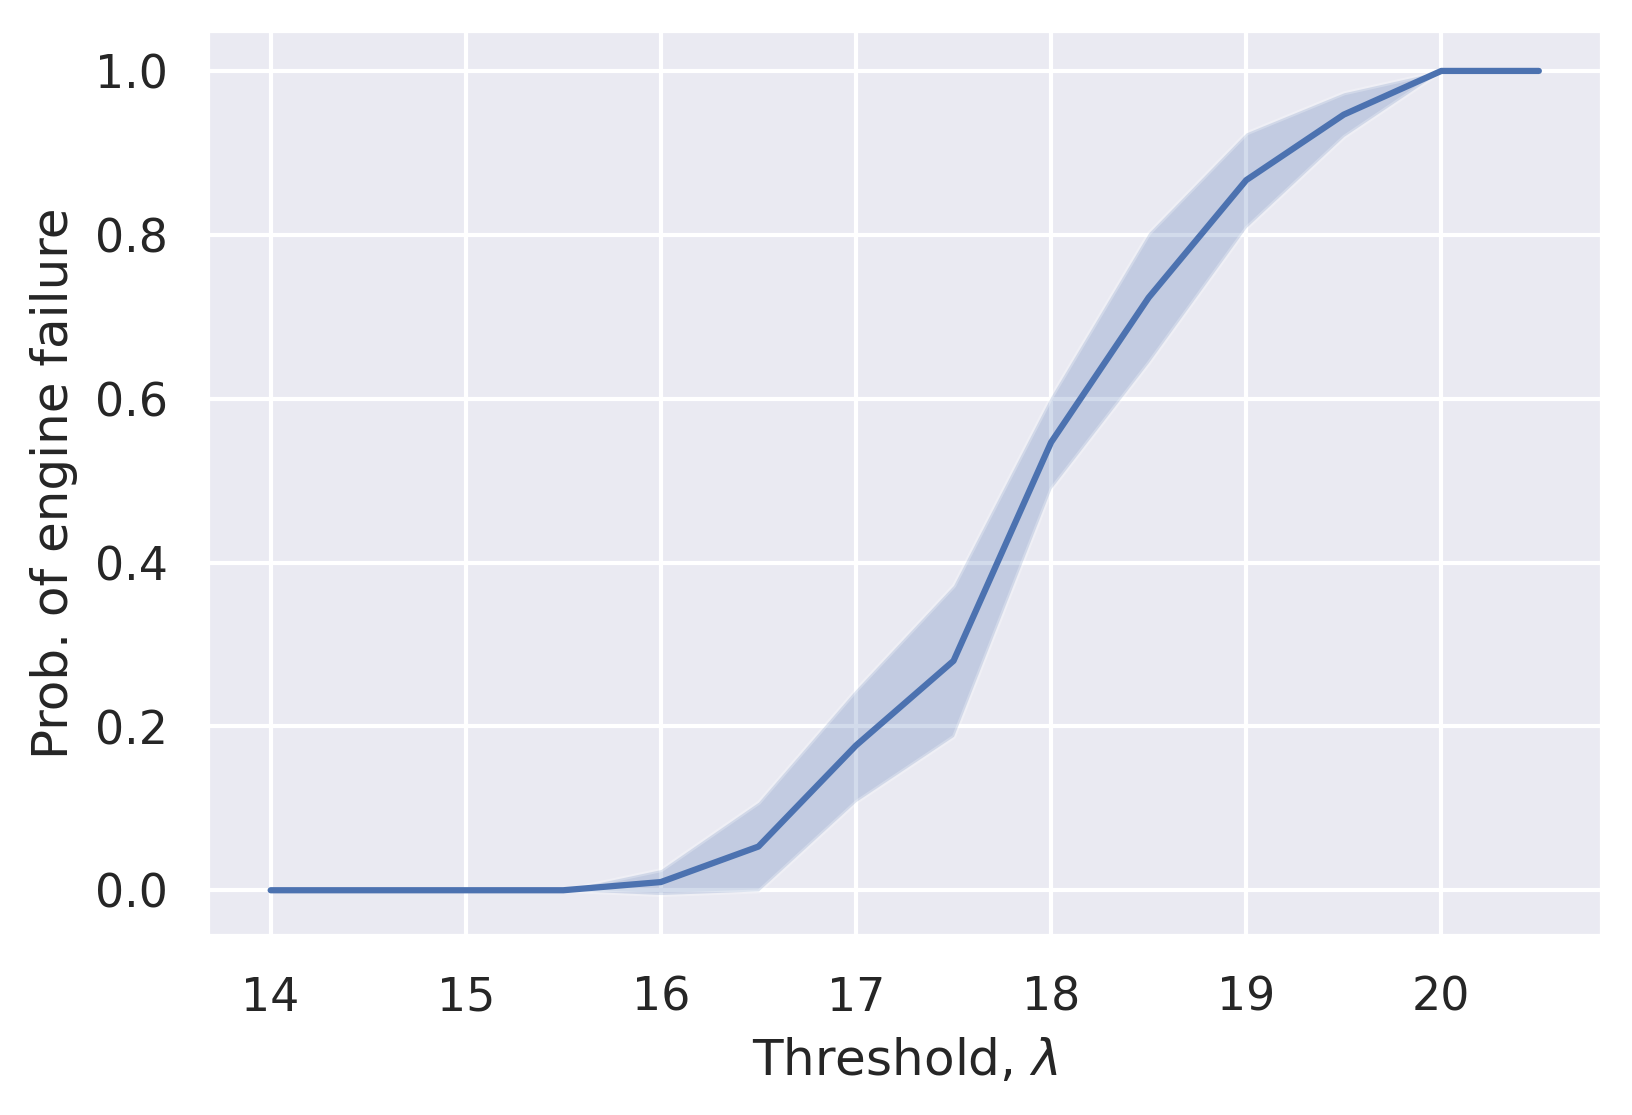

In [13]:
np.save('fd001_mean_', np.array(optim_data_mean))
np.save('fd001_std', np.array(optim_data_std))

mean_ = pd.DataFrame(np.array(optim_data_mean), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])
std_ = pd.DataFrame(np.array(optim_data_std), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])#


opt_thres_idx = mean_['maint_cost'].argmin()
opt_thres = thres_list[opt_thres_idx]

plt.figure(figsize=[4, 4], dpi=300)

plt.plot(thres_list, mean_['perf_rest'], label='Perform. restoration cost')
plt.fill_between(thres_list, mean_['perf_rest'] -std_['perf_rest'],  
                 mean_['perf_rest'] +std_['perf_rest'], alpha=0.25)

plt.plot(thres_list, mean_['llp_rep'], label='LLP replacement cost')
plt.fill_between(thres_list, mean_['llp_rep'] -std_['llp_rep'],  
                 mean_['llp_rep'] +std_['llp_rep'], alpha=0.25)

plt.plot(thres_list, mean_['maint_cost'], label='Total maintenance cost')
plt.fill_between(thres_list, mean_['maint_cost'] -std_['maint_cost'],  
                 mean_['maint_cost'] +std_['maint_cost'], alpha=0.25)

plt.xlabel('Threshold, $\lambda$')
plt.ylabel('$ value')
#plt.legend( fontsize=8)
#plt.title('FD001')
plt.savefig('fd001_cost.pdf', format='pdf')
plt.show()

plt.figure(dpi=300)
plt.plot(thres_list, mean_['fail_prob'], label='Engine failure probability')
plt.fill_between(thres_list, mean_['fail_prob'] -std_['fail_prob'],  
                 mean_['fail_prob'] +std_['fail_prob'], alpha=0.25)
plt.xlabel('Threshold, $\lambda$')
plt.ylabel('Prob. of engine failure')
#plt.title('FD001')
plt.savefig('fd001_prob.pdf', format='pdf')
plt.show()


In [14]:
mean_

,thres,fail_prob,perf_rest,llp_rep,maint_cost
0,14.0,0.000000,105000000.0,0.0,105000000.0
1,14.5,0.000000,105000000.0,0.0,105000000.0
2,15.0,0.000000,105000000.0,0.0,105000000.0
3,15.5,0.000000,98350000.0,0.0,98350000.0
4,16.0,0.010000,87850000.0,1200000.0,89050000.0
5,16.5,0.053333,71750000.0,6400000.0,78150000.0
6,17.0,0.176667,42700000.0,21200000.0,63900000.0
7,17.5,0.280000,26250000.0,33600000.0,59850000.0
8,18.0,0.546667,8050000.0,65600000.0,73650000.0
9,18.5,0.723333,5250000.0,86800000.0,92050000.0


### Testing [We'll ignore this for now and focus on using training set]

In [15]:
#testing

machine_test_i = []
thres = opt_thres
for i in trange(X_test['UnitNumber'].max()):
      X_sub = X_test.loc[X_test['UnitNumber'] == i+1]
      X_fail = X_test.loc[X_test['UnitNumber'] == i+1]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep      
      machine_test_i.append([thres, is_failed, total_perf_rest, total_llp_rep, total_maintcost])

In [16]:
opt_thres

17.5

In [17]:
result_test = pd.DataFrame(np.array(machine_test_i), columns=['thres', 'is_failed', 'perf_rest', 'llp_rep', 'maint_cost'])
result_thres_test = result_test.groupby('thres').sum().reset_index()
result_thres_test['is_failed'] = result_thres_test['is_failed']/X_test['UnitNumber'].max()
result_thres_test


,thres,is_failed,perf_rest,llp_rep,maint_cost
0,17.5,1.0,0.0,400000000.0,400000000.0


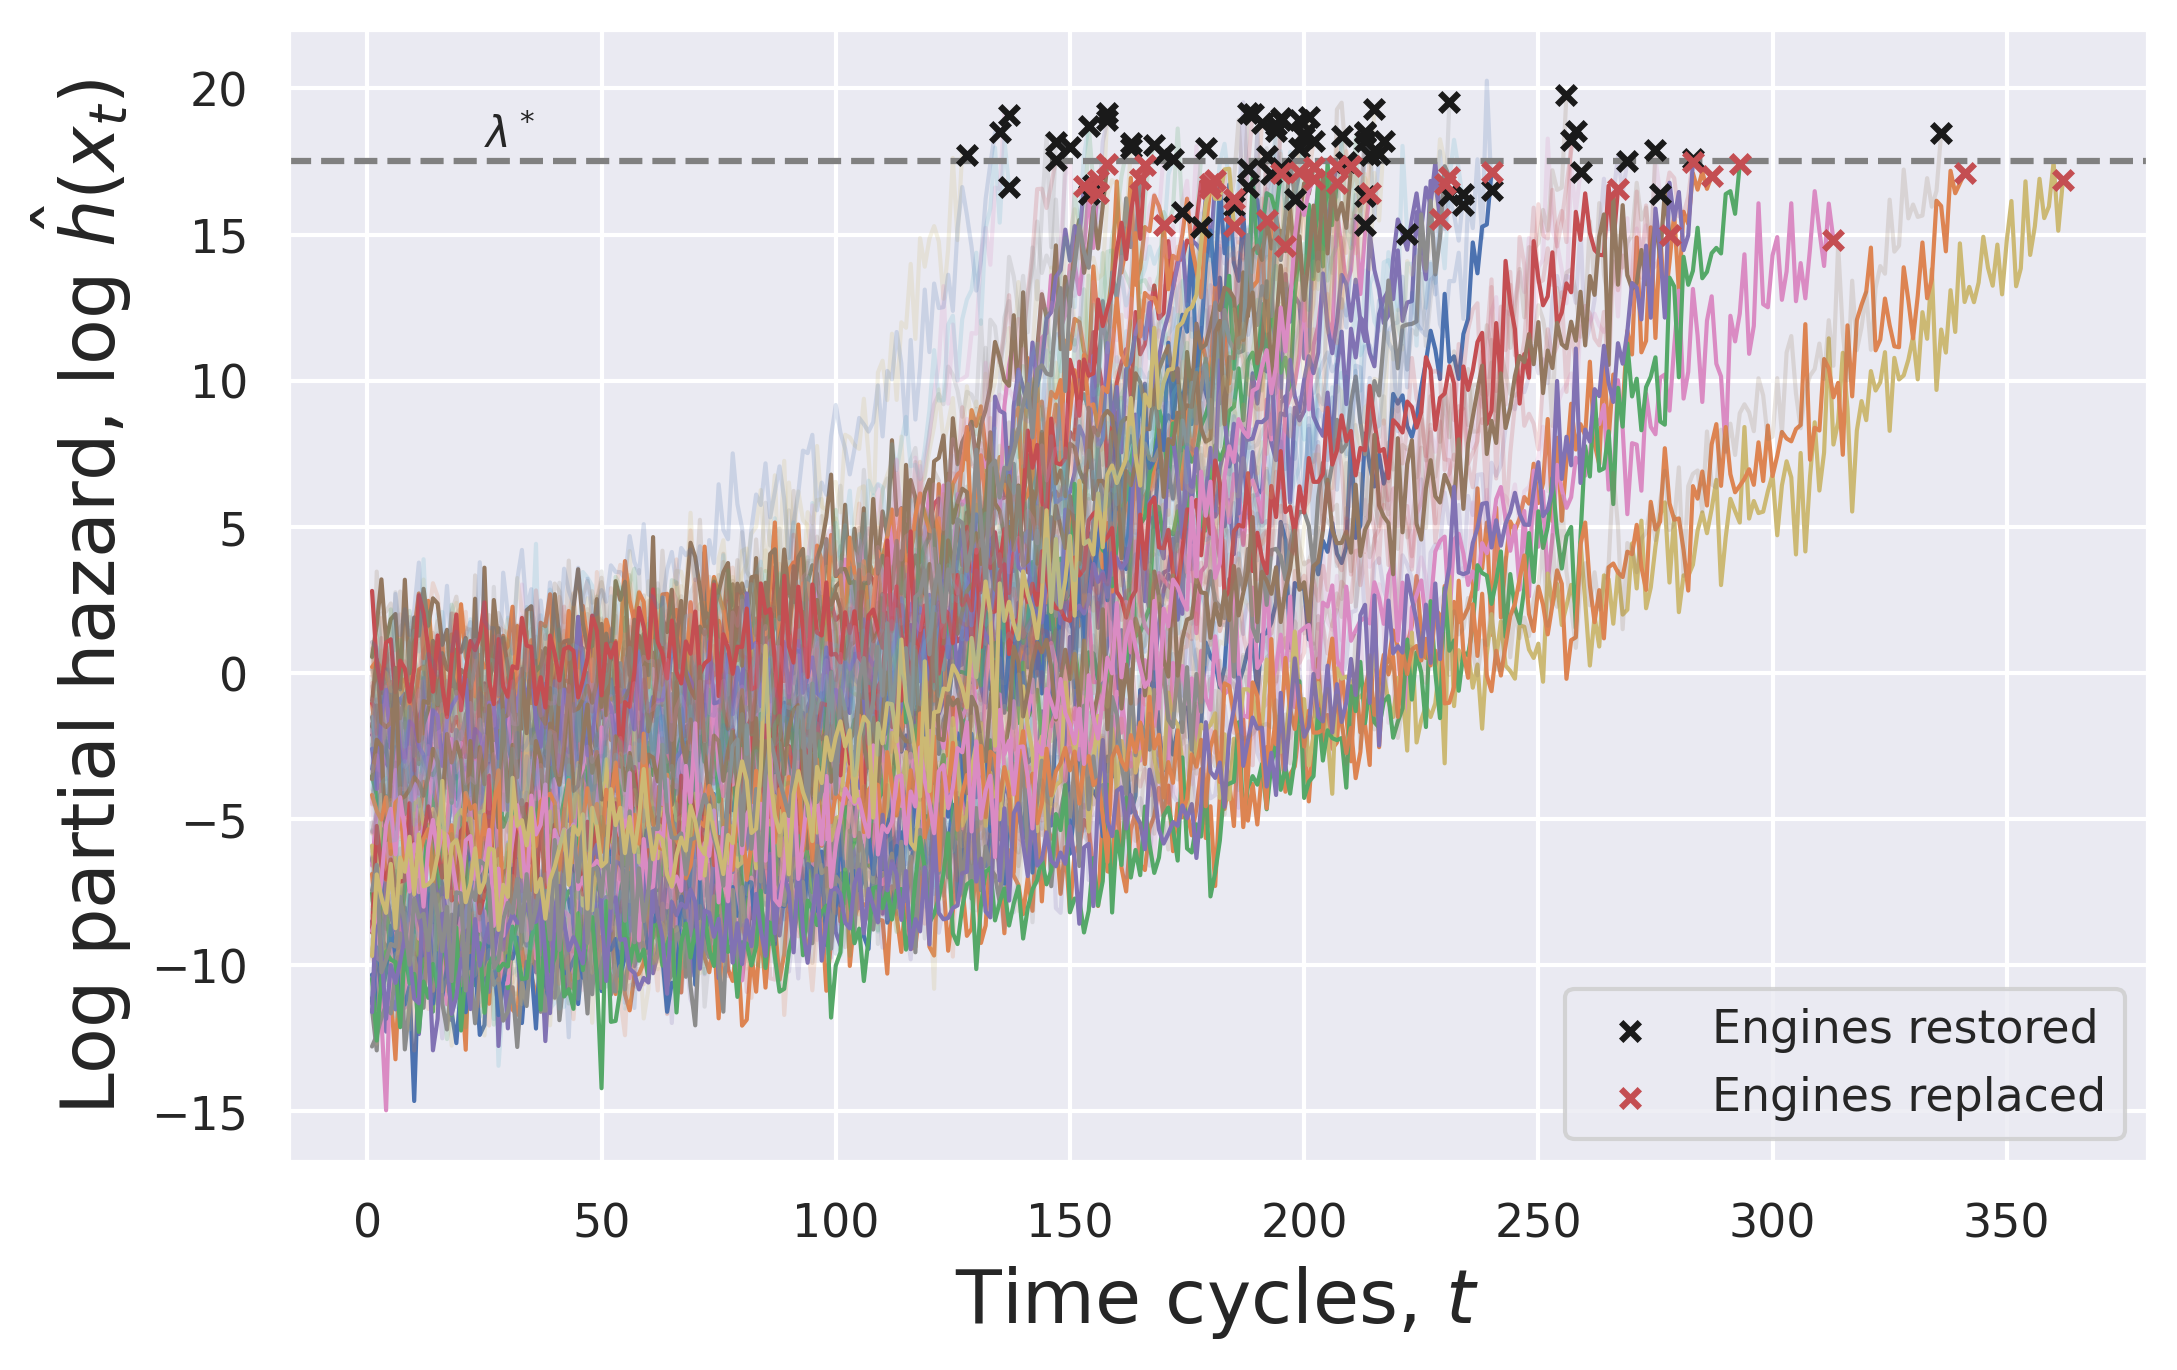

In [18]:
plt.figure(figsize=(8,5), dpi=300)
df_X = X
engines_restored = []
engines_replaced = []
for i in trange(100):
    X_sub = df_X.loc[df_X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    log_partial_hazard = np.log(predictions)
    is_maintained = log_partial_hazard.max() > thres
    plt.plot(X_sub['Cycle'].values, log_partial_hazard, alpha=0.2+0.8*~is_maintained, lw=1)
        
    if is_maintained:
      engines_restored.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])      
    else:
      engines_replaced.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])
engines_restored = np.array(engines_restored)
engines_replaced = np.array(engines_replaced)      

if len(engines_restored) > 0:
  plt.scatter(engines_restored[:, 0], engines_restored[:, 1], s=20, marker="x", zorder=10, c="k", label="Engines restored")  
if len(engines_replaced) > 0:
  plt.scatter(engines_replaced[:, 0], engines_replaced[:, 1], s=20, marker="x", zorder=10, c="r", label="Engines replaced")


plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.text(25, thres+0.5, '$\lambda^*$')
plt.legend()
plt.axhline(thres, c='gray', linestyle="dashed")
plt.savefig('sim_result_fd001.pdf',format="pdf")
plt.show()